In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pickle
import seaborn as sns

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
le = LabelEncoder()

In [14]:
df = pd.read_csv('seattle-weather.csv')
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [15]:
df.shape

(1461, 6)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [17]:
df.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [18]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [19]:
df.drop('date', axis = 'columns', inplace = True)
df['weather'] = le.fit_transform(df['weather'])

In [20]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,0
1,10.9,10.6,2.8,4.5,2
2,0.8,11.7,7.2,2.3,2
3,20.3,12.2,5.6,4.7,2
4,1.3,8.9,2.8,6.1,2


In [21]:
X = df.drop('weather', axis = 'columns')
y = df.weather

In [22]:
oversampler = SMOTE(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [23]:
# Create a new balanced DataFrame
balanced_data = pd.concat([X_resampled, y_resampled], axis=1)

# Display the updated DataFrame
balanced_data.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,0
1,10.9,10.6,2.8,4.5,2
2,0.8,11.7,7.2,2.3,2
3,20.3,12.2,5.6,4.7,2
4,1.3,8.9,2.8,6.1,2


In [24]:
A = balanced_data.drop('weather', axis = 'columns')
B = balanced_data.weather

In [26]:
X_train, X_test, y_train, y_test = train_test_split(A,B, test_size = 0.2, random_state = 42)

In [ ]:
# Pipeline for Random Forest Classifier
rfc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

# Parameters Grid for Random Forest Classifier
rfc_param_grid = {
    'rfc__n_estimators': [100, 200, 300, 500, 1000],
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__max_depth': [None, 5, 10, 20],
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__max_features': ['sqrt', 'log2', None],
    'rfc__bootstrap': [True, False],
    'rfc__class_weight': [None, 'balanced', 'balanced_subsample']
}

# Grid Search for Random Forest Classifier
rfc_grid_search = RandomizedSearchCV(rfc_pipeline, rfc_param_grid, cv=5, scoring='accuracy', n_iter=100, random_state=42)

# Fitting for Random Forest Classifier
rfc_grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score for the pipeline
print("Best Hyperparameters for Random Forest Classifier:")
print(rfc_grid_search.best_params_)
print("Best Score for Random Forest Classifier:", rfc_grid_search.best_score_)

Best Hyperparameters for Random Forest Classifier:
{'rfc__n_estimators': 300, 'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 1, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 20, 'rfc__criterion': 'gini', 'rfc__class_weight': 'balanced', 'rfc__bootstrap': True}
Best Score for Random Forest Classifier: 0.8638896503411306


In [ ]:
y_preds = rfc_grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
cm

array([[102,  10,   0,   0,  16],
       [ 10, 110,   0,   0,   7],
       [  2,   3, 114,   9,   8],
       [  0,   0,   1, 118,   0],
       [ 12,  19,   1,   0,  99]])

<Axes: >

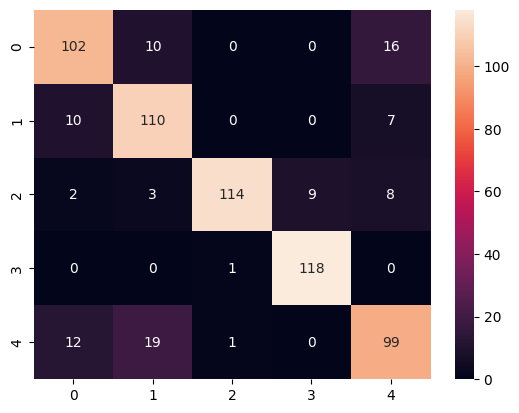

In [ ]:
sns.heatmap(cm, annot = True, fmt = 'g')

In [ ]:
report = classification_report(y_test, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       128
           1       0.77      0.87      0.82       127
           2       0.98      0.84      0.90       136
           3       0.93      0.99      0.96       119
           4       0.76      0.76      0.76       131

    accuracy                           0.85       641
   macro avg       0.85      0.85      0.85       641
weighted avg       0.85      0.85      0.85       641



In [ ]:
pickle.dump(rfc_grid_search, open('weather_model.pkl', 'wb'))